In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from umap import UMAP

from csd_simulations import (
    simulate_no_csd,
    simulate_no_csd_same_z,
    simulate_no_csd_large_z,
    simulate_csd,
    simulate_csd_corr,
)
from models import (
    train_ridge,
    train_rf,
    train_mlp,
    get_prob_metrics
)

np.random.seed(42)

%load_ext autoreload
%autoreload 2

### Simulate data from multiple "domains"

Main simulation code is in `09_simulations/csd_simulations.py`.

In [2]:
n_domains = 5
n_per_domain = 50
p = 10
k = 5
noise_scale = 1.5

simulate_with_csd = True
simulate_same_z = True
correlated_noise = True

In [3]:
if k is not None:
    if simulate_with_csd:
        if correlated_noise:
            # xs, ys = simulate_csd_corr(n_domains, n_per_domain, p, k, corr_top=1., diag=None)
            xs, ys = simulate_csd_corr(n_domains, n_per_domain, p, k, corr_top=0.5, diag=5)
            # xs, ys = simulate_csd_corr(n_domains, n_per_domain, p, k, corr_top=0.1, diag=10)
        else:
            xs, ys = simulate_csd(n_domains, n_per_domain, p, k, noise_scale)
    else:
        xs, ys = simulate_no_csd_large_z(n_domains, n_per_domain, p, k, noise_scale)
elif simulate_same_z:
    xs, ys = simulate_no_csd_same_z(n_domains, n_per_domain, p, noise_scale)
else:
    xs, ys = simulate_no_csd(n_domains, n_per_domain, p, noise_scale)

print(xs.shape)
print(xs[:5, :5])

(250, 10)
[[-0.96153836  3.16928649  3.44038762  1.82525753  3.00300349]
 [ 1.41729526  4.88982431  0.8748816  -1.59765776  6.87077753]
 [-0.870648    4.33523705 -2.37570995 -0.85409482 -0.22645458]
 [-4.60955745  1.76510197 -1.68131369 -1.73556279  3.85473524]
 [ 0.67538656 -1.65619857 -4.75333127  2.09482947 -0.43907953]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(250, 1)
[[-1]
 [-1]
 [ 1]]


### Plot simulated data

We'll do this using both PCA and UMAP, side by side. We can color by domain and use different shapes for each label, to get an idea of how data clusters with respect to domain and how separable we expect different labels to be across domains.

In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,4.174390,11.092740,0,-1
1,4.812818,13.267610,0,-1
2,6.522593,12.777535,0,1
3,6.338870,11.845942,0,-1
4,5.965440,13.151369,0,1


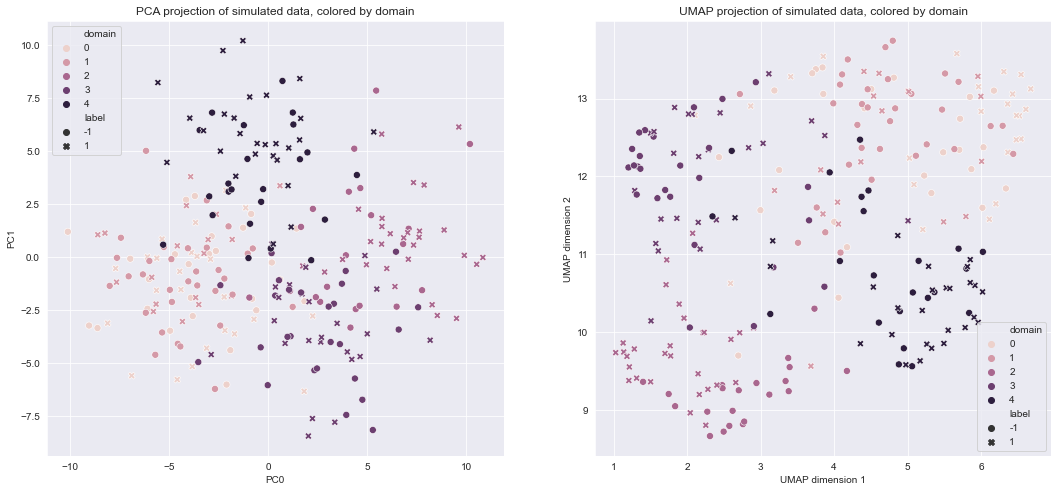

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

### Random train/test splitting

Just split the data randomly here, and fit some models to the split data. This gives us an idea of what baseline performance we should expect when we have access to training data from all domains.

In [7]:
# split dataset into train/test
n_splits = 4
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs)):
    X_train, X_test = xs[train_ix, :], xs[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
 
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    params = {
        'learning_rate': [0.1, 0.01, 0.001, 5e-4, 1e-4],
        'h1_size': [100, 200, 300, 500],
        'dropout': [0.1, 0.5, 0.75],
        'weight_decay': [0, 0.1, 1, 10, 100]
    }
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, n_folds=-1, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.753947
1,random_forest,0,train_auroc,0.882151
2,mlp,0,train_auroc,0.904462
3,ridge,1,train_auroc,0.743704
4,random_forest,1,train_auroc,0.940133


(-0.1, 1.1)

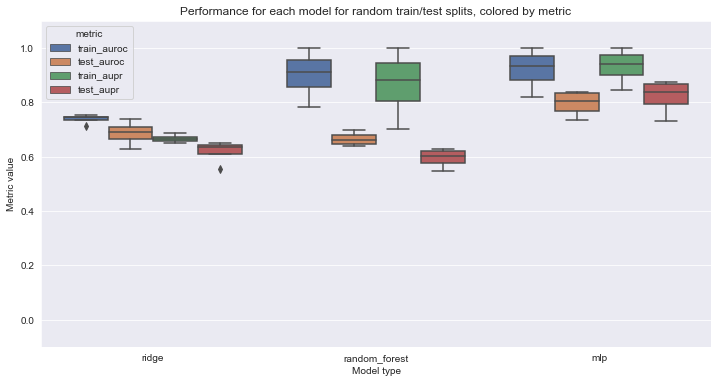

In [8]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.title('Performance for each model for random train/test splits, colored by metric')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

### Domain holdout train/test splitting

Here, we want to hold out a single domain and train on the other domains. This simulates the case when we have access to some domains during training, and we want to measure generalization to domains that we can't train on for whatever reason.

In [9]:
# split dataset into train/test
n_splits = 4
results = []
results_cols = None

holdout_domain = np.unique(domains)[-1]
X_train = xs[domains != holdout_domain, :]
X_holdout = xs[domains == holdout_domain, :]
y_train = ys[domains != holdout_domain, :]
y_holdout = ys[domains == holdout_domain, :]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, test_ix) in enumerate(kf.split(X_holdout)):
    X_test, y_test = X_holdout[test_ix, :], y_holdout[test_ix, :]

    # train linear model with ridge penalty
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)

    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)

    # train random forest model
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)

    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)

    # train 3-layer neural network model
    params = {
        'learning_rate': [0.1, 0.01, 0.001, 5e-4, 1e-4],
        'h1_size': [100, 200, 300, 500],
        'dropout': [0.1, 0.5, 0.75],
        'weight_decay': [0, 0.1, 1, 10, 100]
    }
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, n_folds=-1, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)

    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)

results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.735088
1,random_forest,0,train_auroc,0.845865
2,mlp,0,train_auroc,0.896942
3,ridge,1,train_auroc,0.735088
4,random_forest,1,train_auroc,0.845865


(-0.1, 1.1)

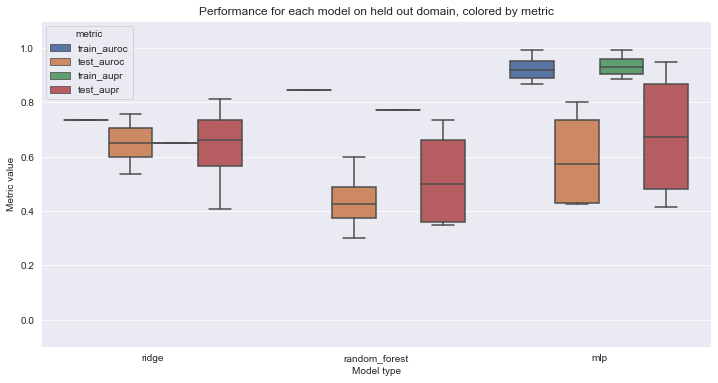

In [10]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.title('Performance for each model on held out domain, colored by metric')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

### CORAL

CORAL

In [11]:
# apply CORAL to map X_train onto X_holdout
from transfertools.models import CORAL

print(X_train.shape, X_holdout.shape)
X_train_coral, X_holdout_coral = CORAL().fit_transfer(X_train, X_holdout)

(200, 10) (50, 10)


In [12]:
# visualize X_train and X_holdout after CORAL transformation
xs_coral = np.concatenate((X_train_coral, X_holdout_coral))
print(xs_coral.shape)

(250, 10)


In [13]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs_coral)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs_coral)

coral_train_test = np.concatenate((
    ['train'] * X_train_coral.shape[0],
    ['test'] * X_holdout_coral.shape[0]
))

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['coral_train_test'] = coral_train_test
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['coral_train_test'] = coral_train_test
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,coral_train_test,label
0,8.979585,7.432098,train,-1
1,10.778661,3.524438,train,-1
2,10.899958,5.755729,train,1
3,10.629927,5.619046,train,-1
4,9.094576,3.972026,train,1


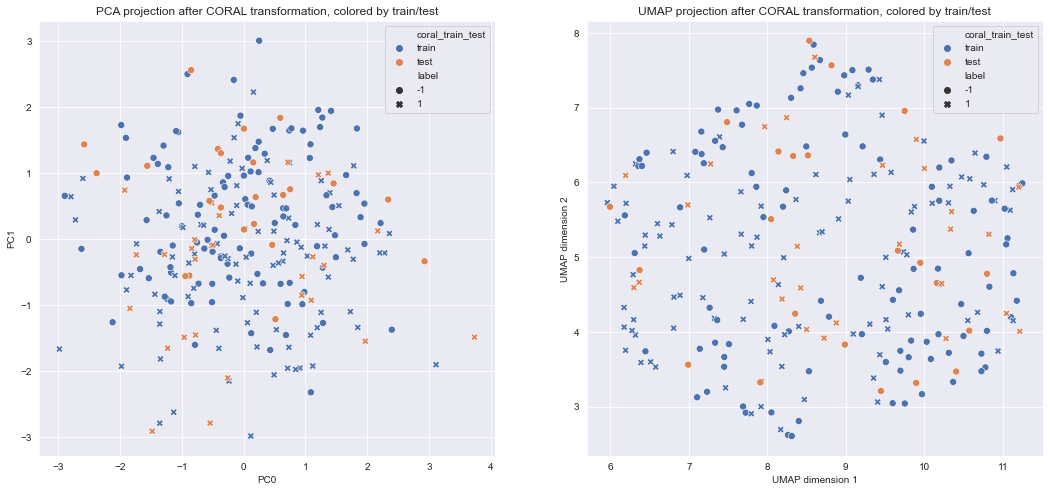

In [14]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='coral_train_test', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='coral_train_test', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection after CORAL transformation, colored by train/test')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection after CORAL transformation, colored by train/test')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

In [15]:
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, test_ix) in enumerate(kf.split(X_holdout_coral)):
    X_test, y_test = X_holdout_coral[test_ix, :], y_holdout[test_ix, :]

    # train linear model with ridge penalty
    fit_pipeline = train_ridge(X_train_coral, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train_coral)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)

    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)

    # train random forest model
    fit_pipeline = train_rf(X_train_coral, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train_coral)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)

    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)

    # train 3-layer neural network model
    params = {
        'learning_rate': [0.1, 0.01, 0.001, 5e-4, 1e-4],
        'h1_size': [100, 200, 300, 500],
        'dropout': [0.1, 0.5, 0.75],
        'weight_decay': [0, 0.1, 1, 10, 100]
    }
    fit_pipeline = train_mlp(X_train_coral, y_train.flatten(), params, n_folds=-1, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train_coral.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)

    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)

coral_results_df = pd.DataFrame(results, columns=results_cols)
coral_results_df = coral_results_df.melt(id_vars=['model', 'fold'], var_name='metric')
coral_results_df.head()

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.735088
1,random_forest,0,train_auroc,0.845865
2,mlp,0,train_auroc,0.896942
3,ridge,1,train_auroc,0.735088
4,random_forest,1,train_auroc,0.845865


(-0.1, 1.1)

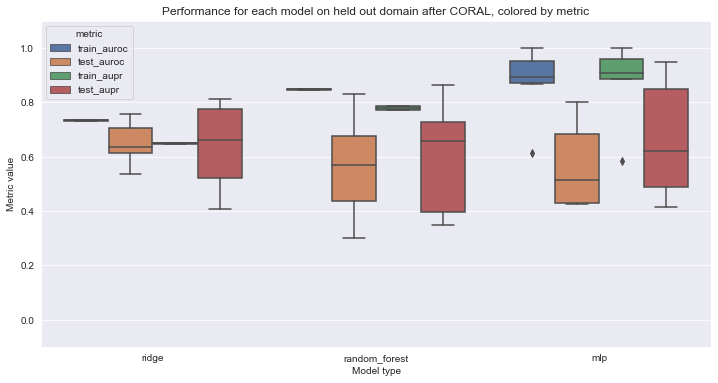

In [16]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=coral_results_df, x='model', y='value', hue='metric')
plt.title('Performance for each model on held out domain after CORAL, colored by metric')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)

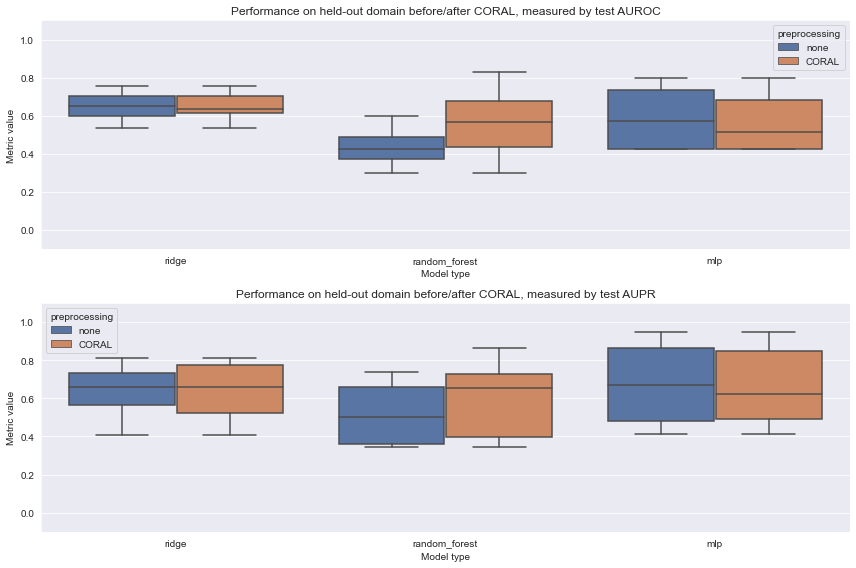

In [17]:
results_df['preprocessing'] = 'none'
coral_results_df['preprocessing'] = 'CORAL'

results_df = pd.concat((results_df, coral_results_df))

sns.set({'figure.figsize': (12, 8)})
fig, axarr = plt.subplots(2, 1)

sns.boxplot(data=results_df[results_df.metric == 'test_auroc'],
            x='model', y='value', hue='preprocessing', ax=axarr[0])
axarr[0].set_title('Performance on held-out domain before/after CORAL, measured by test AUROC')
axarr[0].set_xlabel('Model type')
axarr[0].set_ylabel('Metric value')
axarr[0].set_ylim(-0.1, 1.1)

sns.boxplot(data=results_df[results_df.metric == 'test_aupr'],
            x='model', y='value', hue='preprocessing', ax=axarr[1])
axarr[1].set_title('Performance on held-out domain before/after CORAL, measured by test AUPR')
axarr[1].set_xlabel('Model type')
axarr[1].set_ylabel('Metric value')
axarr[1].set_ylim(-0.1, 1.1)

plt.tight_layout()

### Random split with dummy covariate for domain

Does providing the domain information (in the form of a dummy/one-hot variable) help performance?

In [18]:
x_covariates = pd.get_dummies(domains)
x_covariates.head()

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [19]:
xs_fixed = np.concatenate((xs, x_covariates.values), axis=1)
print(xs_fixed[:5, :]) 

[[-0.96153836  3.16928649  3.44038762  1.82525753  3.00300349  0.02457757
   1.94386288 -0.76631347  3.00002842  3.5963832   1.          0.
   0.          0.          0.        ]
 [ 1.41729526  4.88982431  0.8748816  -1.59765776  6.87077753  3.59676938
  -4.30914455  2.44943405  1.67107504  0.121761    1.          0.
   0.          0.          0.        ]
 [-0.870648    4.33523705 -2.37570995 -0.85409482 -0.22645458 -1.85888486
  -4.09526132  3.26544601  3.51222327 -1.46630413  1.          0.
   0.          0.          0.        ]
 [-4.60955745  1.76510197 -1.68131369 -1.73556279  3.85473524 -3.9316408
   1.16389897  0.3298377   4.21273243  0.38346269  1.          0.
   0.          0.          0.        ]
 [ 0.67538656 -1.65619857 -4.75333127  2.09482947 -0.43907953 -0.2381841
  -7.45201045  1.54930295  3.88606586  0.43206733  1.          0.
   0.          0.          0.        ]]


In [20]:
# split dataset into train/test
# this time with a covariate for domain membership (this should help performance)
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs_fixed)):
    X_train, X_test = xs_fixed[train_ix, :], xs_fixed[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, n_folds=-1, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_prob_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.753947
1,random_forest,0,train_auroc,0.882151
2,mlp,0,train_auroc,0.822712
3,ridge,1,train_auroc,0.738496
4,random_forest,1,train_auroc,0.983516


(-0.1, 1.1)

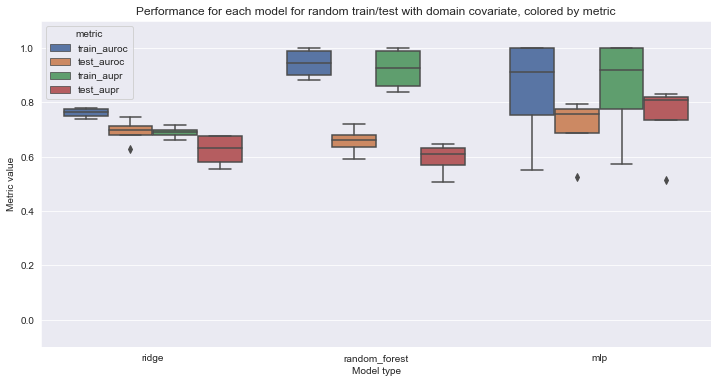

In [21]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.title('Performance for each model for random train/test with domain covariate, colored by metric')
plt.xlabel('Model type')
plt.ylabel('Metric value')
plt.ylim(-0.1, 1.1)